# Imports

In [1]:
import torch
import torchvision
import torchsummary
import numpy as np
import PIL.Image as Image

from torch import nn

# Data

In [2]:
def filter_label(label: np.ndarray):
    label_filtred = label
    label_filtred = label_filtred // 130 * 255 
    label_filtred = label_filtred.reshape(-1, 3)

    for i in range(len(label_filtred)):
        if all(label_filtred[i] == [255, 0, 255]):
            label_filtred[i] = [255, 0, 0]
            
        if all(label_filtred[i] == [255, 255, 0]):
            label_filtred[i] = [255, 0, 0]
            
        if all(label_filtred[i] == [0, 255, 255]):
            label_filtred[i] = [0, 255, 0]
            
        if all(label_filtred[i] == [255, 255, 255]):
            label_filtred[i] = [0, 0, 0]
            
    label_filtred = label_filtred.reshape(label.shape)
    
    return label_filtred

In [11]:
img_path = "input.png"
label_path = "output.png"

In [29]:
pil_image = Image.open(img_path).convert('RGB')
tmp = Image.open(label_path).convert('RGB')
pil_label = Image.fromarray(filter_label(np.array(tmp))).convert('L')

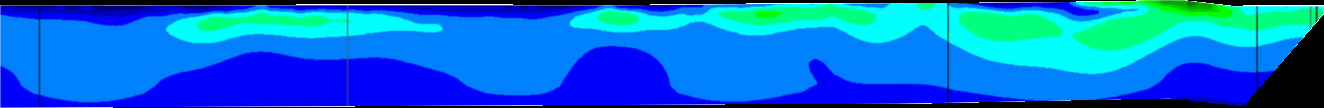

In [30]:
pil_image

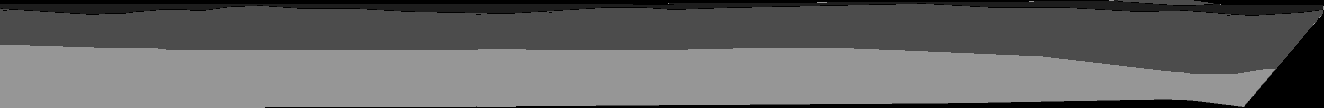

In [31]:
pil_label

In [32]:
image = np.array(pil_image)
label = np.array(pil_label)
image.shape, label.shape

((108, 1324, 3), (108, 1324))

In [16]:
mask = mask_from_label_image(label)*55
mask.shape
Image.fromarray(mask, 'L')

ValueError: cannot reshape array of size 428976 into shape (108,1324)

# Model

In [9]:
""" Parts of the U-Net model """
# Code based on https://github.com/milesial/Pytorch-UNet/tree/master

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [10]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [30]:
NUM_CLASSES = 16
model = UNet(3, NUM_CLASSES).to("cuda")

In [31]:
tensor_image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1)[None, ...].to("cuda")
tensor_image.shape

torch.Size([1, 3, 108, 1324])

In [32]:
rez = model(tensor_image)

In [33]:
rez_image = rez.detach().cpu()[0].permute(1, 2, 0)
mask = rez.argmax(dim=1).cpu().permute(1, 2, 0).squeeze().numpy().astype(np.uint8) * 55
mask.shape

(108, 1324)

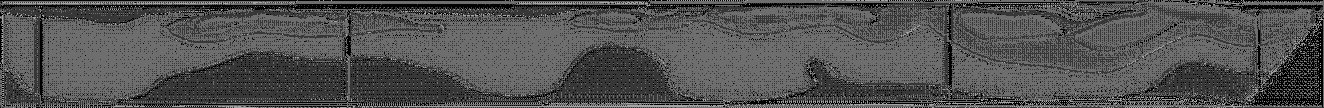

In [34]:
pil_rez_image = Image.fromarray(mask, 'L')
pil_rez_image

In [35]:
mask

array([[  0,   0,   0, ...,   0,   0, 110],
       [ 55,  55, 110, ..., 110, 110, 110],
       [ 55,   0, 110, ..., 110, 110, 110],
       ...,
       [ 55, 110, 165, ..., 110,   0, 110],
       [ 55, 110, 110, ..., 110,   0, 110],
       [  0, 110,  55, ...,  55,  55,  55]], dtype=uint8)

In [ ]:
opt = torch.optim.Adam(model.parameters())
loss_func = torch.nn.MSELoss()

In [ ]:
class Dataset:
    def __init__(self) -> None:
        pass

In [ ]:
data = Dataset()

In [ ]:
for image, label in data:
    model.zero_grad()
    predict = model(image)
    loss = loss_func(predict, label)
    loss.bacward()
    opt.step()